In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past, shorten a
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_hard(a, N=3):
    # hard edged rolling avg, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(N,len(a)-N,1):
        b[i] = np.mean(a[i-N:i+N])
    return b

def N_avg_soft(a, N=3):
    # soft edged rolling avg, preseve len a 
    b = np.zeros(len(a))
    for i in range(len(a)):
        l = max(0,i-N)
        r = min(i+N+1, len(a))
        b[i] = np.mean(a[l:r])
    return b

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=covidOccupiedMVBeds&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-27


In [4]:
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&metric=covidOccupiedMVBeds&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions = pd.DataFrame(response['body'])
df_regions['dateTime'] = pd.to_datetime(df_regions['date'])
df_regions.sort_values(by=['dateTime'], inplace=True)
df_regions.dropna(inplace=True)

top_date = sorted(list(set(df_regions.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-27


In [5]:
# input defs
train_in_stream = []
train_out_stream = []
dates_train = []
test_in_stream = []
test_out_stream = []
dates_test = []

in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2020-10-01" 
train_end_date = "2021-04-01"
test_start_date = "2021-10-01"
test_end_date = top_date

#train_start_date = "2021-07-01" 
#train_end_date = "2021-12-01"
#test_start_date = "2021-10-01"
#test_end_date = top_date

In [6]:
# set data: England +ve tests -> hosp admissions
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.covidOccupiedMVBeds.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.covidOccupiedMVBeds.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "admitted"
out_event = "mv bed occup"
geographical_context = "England"

In [7]:
# set data: Regional +ve tests -> hosp admissions
region = "London"
df = df_regions[df_regions.areaName==region]

train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.covidOccupiedMVBeds.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.covidOccupiedMVBeds.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "admitted"
out_event = "mv bed occup"
geographical_context = region

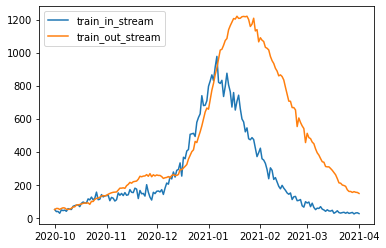

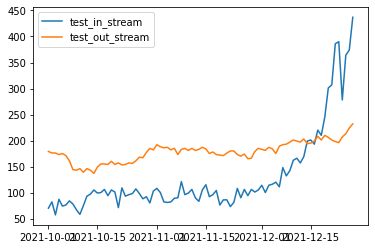

In [8]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [9]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [10]:
n_dim = 60
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = -0.005*np.ones(n_dim)
options = {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2021-12-30 15:17:39,672 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=21.2
2021-12-30 15:17:51,231 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 21.224719220491014, best pos: [ 0.03287844  0.06253211  0.06190549  0.0997437   0.0277025   0.04520545
  0.08499382  0.06103566  0.04320482  0.04238656  0.05746557  0.07050306
  0.09996198  0.0797047   0.0493618   0.07437001  0.01429495  0.02425755
  0.06034051  0.04455567  0.04199639  0.01867684  0.0217852   0.02481278
  0.03786739  0.02904473  0.01642585  0.02746844  0.03569169  0.01573939
  0.0169182   0.00901247  0.03398012  0.06118963  0.01158691  0.03246594
  0.01509833 -0.00440345  0.06310443  0.01511031 -0.00464574 -0.0039756
  0.02565199  0.02434215 -0.00476385 -0.00469996 -0.00471936 -0.00382933
 -0.00442919 -0.00496389  0.05175003  0.03897251 -0.00043962 -0.00408943
  0.01223346 -0.0029

2021-12-30 15:19:15,320 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=20.3
2021-12-30 15:19:26,913 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 20.318668707720775, best pos: [ 0.04232338  0.04992595  0.05761021  0.06949431  0.06771253  0.00786035
  0.0546603   0.04914327  0.05800868  0.0557134   0.09994008  0.0998973
  0.05119092  0.06351407  0.04363358  0.02751682  0.07433866  0.04671297
  0.01735418  0.03836116  0.06722945  0.08377301  0.03747492  0.00604221
  0.03756549  0.05129251  0.01891495  0.04348828  0.00866231  0.01813994
  0.02915556  0.03870323  0.01998971  0.01549197  0.01181494 -0.00122311
 -0.00272711 -0.00183573 -0.0046992   0.02710922  0.02835603 -0.00471397
  0.02464948 -0.00323315  0.05047605  0.01093592 -0.00446598  0.02680145
  0.03099982 -0.00481961 -0.00468118 -0.00487953  0.01348114  0.04424408
 -0.00300284 -0.0005

2021-12-30 15:20:35,804 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.7, 'c2': 0.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=26.5
2021-12-30 15:20:41,801 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 26.45134281778859, best pos: [ 0.07122874  0.06429599  0.07255613  0.03833126  0.05688339  0.05078477
  0.04682151  0.05617111  0.05843228  0.04615709  0.04097     0.02683978
  0.02007821  0.02325201  0.05695718  0.06344012  0.04199805  0.09994125
  0.08908629  0.01942263  0.06330987  0.05296602  0.05133247  0.06566266
  0.05076366  0.01281084  0.02817108 -0.00390784 -0.00262288  0.03555037
 -0.00037554  0.06112733  0.01417877 -0.00469975  0.03384171  0.00512634
  0.04813163  0.00559388  0.01899989  0.05447474  0.02711243 -0.0048442
 -0.00494525  0.01236743  0.01623039 -0.0049539  -0.00483553  0.03532242
 -0.00451505 -0.00475722  0.00454971 -0.00070336 -0.00302349  0.0042981
  0.0104368   0.018135

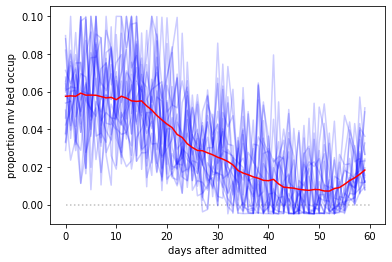

<Figure size 432x288 with 0 Axes>

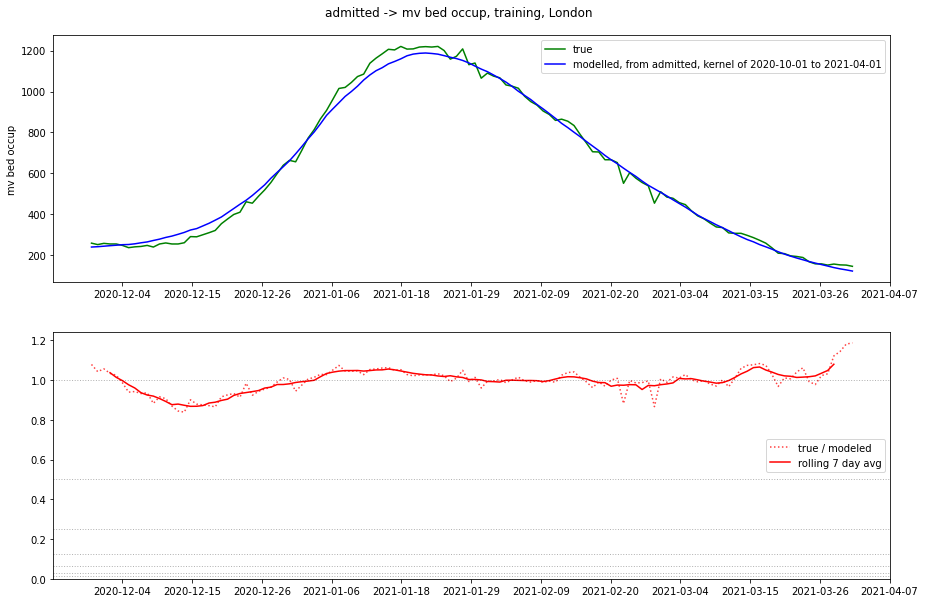

<Figure size 432x288 with 0 Axes>

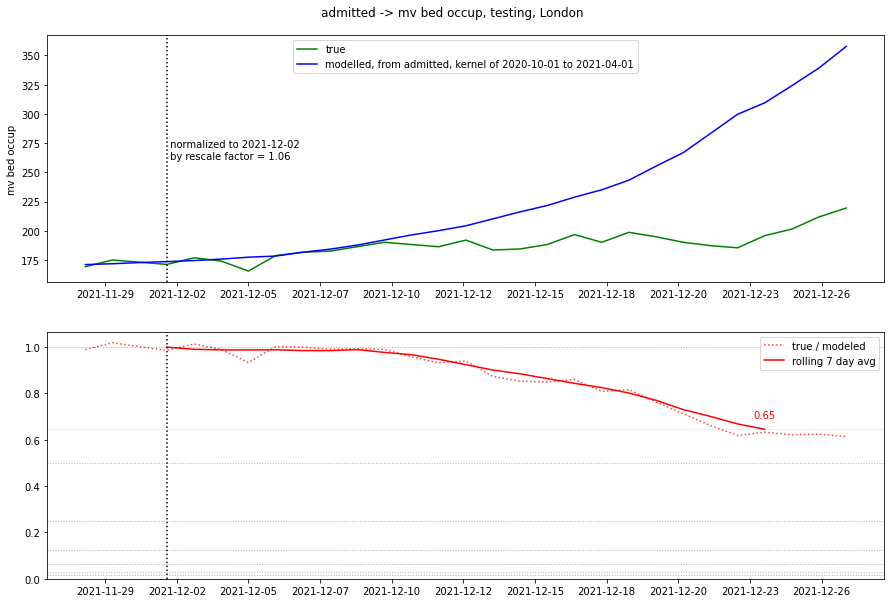

In [25]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, y, color="blue", alpha=0.2)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
avg_minimizer = N_avg_soft(avg_minimizer, 3) 
plt.plot(z, avg_minimizer, color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.25, color="black")
plt.savefig("%s__%s__kernel__%s.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes   
    
    true, pred = _f(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    diff = true/pred
    avg_diff = N_avg_hard(diff, 3)
    rescale_factor = 1
    if test_train=="test":
        rescale_factor = avg_diff[np.isfinite(avg_diff)][0]
    
    ax1.plot(x, true/rescale_factor, color="green", label="true")
    modeled_label = "modelled, from %s, kernel of %s to %s" % (in_event, train_start_date, train_end_date)
    ax1.plot(x, pred, color="blue", label=modeled_label)
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, diff/rescale_factor, color="red", alpha=0.75, ls="dotted", label="true / modeled")
    ax2.plot(x, avg_diff/rescale_factor, color="red", label="rolling 7 day avg")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))

    if test_train=="test":
        end_level = avg_diff[np.isfinite(avg_diff)][-1]
        ax2.axvline(x=x[3], color="black", ls="dotted")
        ax1.axvline(x=x[3], color="black", ls="dotted")
        y_min,y_max = ax1.get_ylim()
        y_mid = (y_min+y_max)/2 
        ax1.text(x[3], y_mid, " normalized to %s\n by rescale factor = %.2f" % (x[3].strftime("%Y-%m-%d"), rescale_factor), ha="left")
        ax2.axhline(y=end_level/rescale_factor, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-4], end_level/rescale_factor+0.05, "%.2f" % (end_level/rescale_factor), ha="center", color="red")    
    
    fig.suptitle("%s -> %s, %sing, %s" % (in_event, out_event, test_train, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 






In [16]:
print(avg_minimizer)

[0.05736429 0.0574628  0.05771279 0.05770498 0.05970016 0.05818944
 0.05850349 0.05794285 0.05722614 0.0541902  0.05608646 0.05629098
 0.05745966 0.0573613  0.05571307 0.0542162  0.05327278 0.04889207
 0.04738007 0.04661751 0.043571   0.03847328 0.03810862 0.03516254
 0.03251749 0.02966277 0.02920262 0.02658394 0.02633564 0.0266823
 0.02697809 0.02526647 0.02321337 0.02121199 0.0176055  0.01462606
 0.0149512  0.0153501  0.01385193 0.01327014 0.01392247 0.01190356
 0.01119542 0.00969839 0.00873349 0.00835727 0.00769918 0.00650223
 0.00744867 0.00884345 0.00835483 0.00764958 0.00712607 0.00683258
 0.007853   0.00893161 0.01283707 0.0160796  0.01830932 0.01887487]
